# CNN with tensorflow saver and restore

In [1]:
"""A very simple MNIST classifier.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import numpy as np

import tensorflow as tf

slim = tf.contrib.slim

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))

np.random.seed(1)
tf.set_random_seed(1)

/home/jk/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data / 255.
train_labels = np.asarray(train_labels, dtype=np.int32)

test_data = test_data / 255.
test_labels = np.asarray(test_labels, dtype=np.int32)

# # for fast learning with small dataset
# N = 200
# train_data = train_data[:N]
# train_labels = train_labels[:N]

label = 5


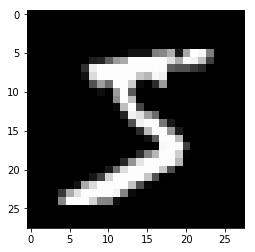

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = 0
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index].reshape(28, 28), cmap='gray')
plt.show()

In [4]:
batch_size = 32

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.shuffle(buffer_size = 10000)
test_dataset = test_dataset.batch(batch_size = len(test_data))
print(test_dataset)

<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float64, tf.int32)>
<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float64, tf.int32)>


In [5]:
# tf.data.Iterator.from_string_handle의 output_shapes는 default = None이지만 꼭 값을 넣는 게 좋음
handle = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle(handle,
                                               train_dataset.output_types,
                                               train_dataset.output_shapes)
x, y = iterator.get_next()
x = tf.cast(x, dtype = tf.float32)
y = tf.cast(y, dtype = tf.int32)

In [6]:
def cnn_model_fn(x):
    """Model function for CNN.
    Args:
    x: input images
    mode: boolean whether trainig mode or test mode

    Returns:
    logits: unnormalized score funtion
    """
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    with tf.name_scope('reshape'):
        x_image = tf.reshape(x, [-1, 28, 28, 1])

    # Convolutional Layer #1
    # Input Tensor Shape: [batch_size, 28, 28, 1]
    # Output Tensor Shape: [batch_size, 28, 28, 32]
    conv1 = slim.conv2d(x_image, 32, [5, 5], scope='conv1')


    # Pooling Layer #1
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 32]
    pool1 = slim.max_pool2d(conv1, [2, 2], scope='pool1')

    # Convolutional Layer #2
    # Input Tensor Shape: [batch_size, 14, 14, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 64]
    conv2 = slim.conv2d(pool1, 64, [5, 5], scope='conv2')

    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 14, 14, 64]
    # Output Tensor Shape: [batch_size, 7, 7, 64]
    pool2 = slim.max_pool2d(conv2, [2, 2], scope='pool2')

    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 7, 7, 64]
    # Output Tensor Shape: [batch_size, 7 * 7 * 64]
    pool2_flat = slim.flatten(pool2, scope='flatten')

    # Fully connected Layer
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    fc1 = slim.fully_connected(pool2_flat, 1024, scope='fc1')

    # Add dropout operation; 0.6 probability that element will be kept
    is_training = tf.placeholder(tf.bool)
    fc1_drop = slim.dropout(fc1, keep_prob=0.6, is_training=is_training, scope='dropout')

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = slim.fully_connected(fc1_drop, 10, activation_fn=None, scope='logits')

    return logits, is_training, x_image

In [7]:
logits, is_training, x_image = cnn_model_fn(x)

In [8]:
cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)

train_op = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [9]:
train_dir = 'graphs/train/'
print('Saving graph to: %s' % train_dir)
train_writer = tf.summary.FileWriter(train_dir)
train_writer.add_graph(tf.get_default_graph()) 

Saving graph to: graphs/train/


In [10]:
with tf.name_scope('summaries'):
    tf.summary.scalar('loss/cross_entropy', cross_entropy)
    tf.summary.image('images', x_image)
    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name, var)
    # merge all summaries
    summary_op = tf.summary.merge_all()

# tf saver

In [11]:
# Create a saver object
saver = tf.train.Saver()

In [12]:
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

# train_iterator
train_iterator = train_dataset.make_initializable_iterator()
train_handle = sess.run(train_iterator.string_handle())

# Train
max_epochs = 2
step = 0
for epochs in range(max_epochs):
    sess.run(train_iterator.initializer)

    start_time = time.time()
    while True:
        try:
            _, loss = sess.run([train_op, cross_entropy],
                             feed_dict={handle: train_handle,
                                        is_training: True})
            if step % 10 == 0:
                print("step: {}, loss: {}".format(step, loss))

                # summary
                summary_str = sess.run(summary_op,
                                       feed_dict={handle: train_handle,
                                                  is_training: False})
                train_writer.add_summary(summary_str, global_step=step)

            step += 1

        except tf.errors.OutOfRangeError:
            print("End of dataset")  # ==> "End of dataset"
            break

    # Save a model per every one epoch in periodically
    if epochs % 2 == 0:
        print("Save model at {} epochs".format(epochs))
        saver.save(sess, train_dir + 'model.ckpt', global_step=step)

    print("Epochs: {} Elapsed time: {}".format(epochs, time.time() - start_time))
#     print("\n")

train_writer.close()
print("training done!")

step: 0, loss: 2.3054018020629883
step: 10, loss: 2.152693271636963
step: 20, loss: 1.9872583150863647
step: 30, loss: 1.8255133628845215
step: 40, loss: 1.6476857662200928
step: 50, loss: 1.385237216949463
step: 60, loss: 1.0713540315628052
step: 70, loss: 0.9330483675003052
step: 80, loss: 0.6298819780349731
step: 90, loss: 0.4742966294288635
step: 100, loss: 0.5777295827865601
step: 110, loss: 0.43588483333587646
step: 120, loss: 0.5337479114532471
step: 130, loss: 0.7679741382598877
step: 140, loss: 0.47654175758361816
step: 150, loss: 0.4634859561920166
step: 160, loss: 0.5241920948028564
step: 170, loss: 0.6299886703491211
step: 180, loss: 0.35555118322372437
step: 190, loss: 0.4733356833457947
step: 200, loss: 0.2536178529262543
step: 210, loss: 0.3214131295681
step: 220, loss: 0.3674960732460022
step: 230, loss: 0.4189661741256714
step: 240, loss: 0.6117838025093079
step: 250, loss: 0.13731563091278076
step: 260, loss: 0.4073445200920105
step: 270, loss: 0.5219544172286987
step

# restore pretrained tf saver

In [13]:
# Create a saver object for restoring
saver = tf.train.Saver()

In [14]:
checkpoints_dir = 'graphs/train/'

In [15]:
sess = tf.Session(config=sess_config)

# read the lastest model checkpoint
model_ckpt = tf.train.latest_checkpoint(checkpoints_dir)
print(model_ckpt)
# use saver object to load variables from the saved model
saver.restore(sess, model_ckpt)

graphs/train/model.ckpt-1704
INFO:tensorflow:Restoring parameters from graphs/train/model.ckpt-1704


In [16]:
# test_iterator
test_iterator = test_dataset.make_initializable_iterator()
test_handle = sess.run(test_iterator.string_handle())
sess.run(test_iterator.initializer)

In [17]:
accuracy, acc_op = tf.metrics.accuracy(labels=y, predictions=tf.argmax(logits, 1), name='accuracy')
sess.run(tf.local_variables_initializer())

sess.run(acc_op, feed_dict={handle: test_handle, is_training: False})
print("test accuracy:", sess.run(accuracy, feed_dict={handle: test_handle, is_training: False}))

test accuracy: 0.9755


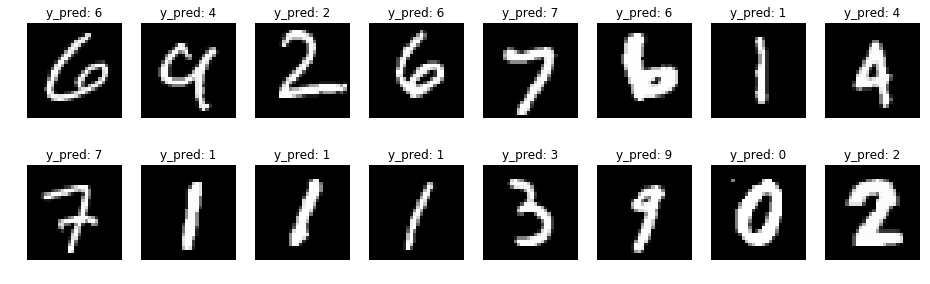

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)
batch_xs = test_data[batch_index]
y_pred = sess.run(logits, feed_dict={x: batch_xs, is_training: False})

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred)):
    p = fig.add_subplot(4, 8, i+1)
    p.set_title("y_pred: {}".format(np.argmax(py)))
    p.imshow(px.reshape(28, 28), cmap='gray')
    p.axis('off')